# Digit Classification Naive Bayes



In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'0.22.2.post1'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False, as_frame=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Applying a smoothing using numpy.
---

A common image processing technique is to smooth an image by **blurring**. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
1. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  1. Do not use the filter
  1. Filter the training data but not the dev data
  1. Filter the dev data but not the training data
  1. Filter both training data and dev data
1. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
1. Experiment with weights that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
* In addition, you can use numpy to multiply and sum slices of two arrays.
* [This notebook](https://colab.research.google.com/drive/1eJXTQLtREXQjQIsLOA9uCrBl6B049-pO) might help shows some example numpy code.
* In general, [numpy operations will be much faster than for loops](https://colab.research.google.com/drive/1KJI4JtuIqVdyZHTTe_mAlKYA5XdLFp3_). 
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but in this question, please implement your own.

In [4]:
def Q1():
  '''Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels and applies in 4 different ways with respective model accuracies'''
### STUDENT START ##
  # Defining the weights: 
  weights = 1/9 * np.ones((3,3))
  def blur(data, weights):
    '''Helper function that blurs each image in a dataset'''
    # Creating a new array of the same shape as the data, but with placeholder 0's: 
    blurred = np.zeros((28,28))
    # Using np.pad to create a border of extra 0s in the original array to help with edge cases: 
    data = np.pad(data.reshape(28, 28), 1)
    # Creating a nested for loop to iterate through the data:
    for row in range(28): 
      for column in range(28): 
        #Updating each value to be the weighted average of each slice of neighbors around that value and multiplying the neighbors matrix by the weights:
        blurred[row, column] = np.sum(data[row:row + 3, column:column + 3] * weights)
    return blurred

  # Filtering the mini train data and dev data as their own variables, making sure to reshape the data for subsequent steps:
  blurred_mini_train_data = [blur(image.reshape((28, 28)), weights) for image in mini_train_data]
  blurred_mini_train_data = np.array(blurred_mini_train_data).reshape((1000, 784))

  blurred_dev_data = [blur(image.reshape((28, 28)), weights) for image in dev_data]
  blurred_dev_data = np.array(blurred_dev_data).reshape((1000, 784))

  # Producing and evaluating four 1-Nearest Neighbor models by applying the blur filter in the 4 ways specified in the directions: 
  print("1. Do not use the filter")
  model1 = KNeighborsClassifier(n_neighbors=1)
  model1.fit(mini_train_data, mini_train_labels)
  model1_predictions = model1.predict(dev_data) 
  print("Model Accuracy: " + str(accuracy_score(dev_labels, model1_predictions)))
  print('\n') 

  print("2. Filter the training data but not the dev data")
  model2 = KNeighborsClassifier(n_neighbors=1)
  model2.fit(blurred_mini_train_data, mini_train_labels)
  model2_predictions = model2.predict(dev_data) 
  print("Model Accuracy: " + str(accuracy_score(dev_labels, model2_predictions)))
  print('\n') 

  print("3. Filter the dev data but not the training data")
  model3 = KNeighborsClassifier(n_neighbors=1)
  model3.fit(mini_train_data, mini_train_labels)
  model3_predictions = model3.predict(blurred_dev_data) 
  print("Model Accuracy: " + str(accuracy_score(dev_labels, model3_predictions)))
  print('\n') 

  print("4. Filter both training data and dev data")
  model4 = KNeighborsClassifier(n_neighbors=1)
  model4.fit(blurred_mini_train_data, mini_train_labels)
  model4_predictions = model4.predict(blurred_dev_data) 
  print("Model Accuracy: " + str(accuracy_score(dev_labels, model4_predictions)))
  print('\n') 
  ### STUDENT END ###

Q1()

1. Do not use the filter
Model Accuracy: 0.884


2. Filter the training data but not the dev data
Model Accuracy: 0.907


3. Filter the dev data but not the training data
Model Accuracy: 0.868


4. Filter both training data and dev data
Model Accuracy: 0.905




ANSWER: As observed with the model accuracies above, the model score ranges from 86.8% to 90.7%, with an average model accuracy of about 89.1%. The difference between the accuracies of the models is very small in the case where I filter the mini train data, with a difference of about 0.2%. The accuracy is the greatest (90.7%) when the mini train data is blurred, but the dev data is not. This is reasonable since pre-processing the training data by blurring it can make it more generalizable when predicting the dev data, whereas generalizing the dev data does not make sense. 

In terms of experimenting with weights that make model accuracy atleast 0.9, I used a method that yields the weighted average of each slice of neighbors around that value, which yielede a relatively high accuracy.

1/(value + 8 neighboring values = 9) * np.ones(((value + value to the left + value to the right = 3),value + value to the left + value to the right = 3())

--> Based on Kernel Filters Notebook provided:)

### Question 2: Modeling your data and experimenting with different Naive Bayes models. 
---

1. Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.
  1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.
  1. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Here you'll likely need to implement a `trianarize` helper function. Since we are going beyond the binary representation of our features, you should use `MultinomialNB` to produce the model.
1. Show the Bernoulli model accuracy and the Multinomial model accuracy.
1. Does the multinomial version improve the results? Why or why not?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.



In [5]:
# Solution with binarization by explicit binarize function

def Q2():
  '''Produces 2 Naive Bayes models (Bernoulli and Multinomial) and evaluates their performances'''

### STUDENT START ###
  # Developing explicit binarize function that maps pixel values to either 0 or 1, representing white or black (with a threshold of 0.1):
  def binarize(data):
    '''Maps pixel values to either 0 or 1, representing white or black (with a threshold of 0.1)'''
    data[np.where(mini_train_data < 0.1)] = 0
    data[np.where(mini_train_data >= 0.1)] = 1
    return data

  #Binarizing the mini train data: 
  binarized_mini_train_data = binarize(mini_train_data)
    
  # Using BernoulliNB to produce the model (Alternate Method: BernoulliNB(binarize = 0.1)): 
  binary_nb = BernoulliNB()
  # Fitting the model on the binarized mini train data and mini train labels: 
  binary_nb.fit(binarized_mini_train_data, mini_train_labels)

  # Predicting on dev data: 
  binary_nb_predicted = binary_nb.predict(dev_data)
  # Obtaining accuracy of the model using accuracy_score and normalization: 
  binary_nb_accuracy_score = accuracy_score(dev_labels, binary_nb_predicted, normalize=True)

  # Printing evaluation: 
  print("Bernoulli Model Accuracy: " + str(binary_nb_accuracy_score))

  # Developing trianarize function that map pixel values to either 0, 1, or 2, representing white, gray, or black - setting the white/gray/black separation thresholds to 0.1 and 0.9:
  def trianarize(data):
    '''Maps pixel values to either 0, 1, or 2, representing white, gray, or black (with thresholds of 0.1 and 0.9)'''
    data[np.where(mini_train_data >= 0.9)] = 2
    data[np.where((mini_train_data >= 0.1) & (mini_train_data < 0.9))] = 1
    data[np.where(mini_train_data < 0.1)] = 0
    return data

  # Creating a mutable copy of the mini train data for subsequent steps:
  mini_train_data_copy = mini_train_data.copy()

  # Trianarizing the mini train data: 
  trianarized_mini_train_data = trianarize(mini_train_data_copy)

  # Using MultinomialNB to produce the model: 
  multinomial_nb = MultinomialNB()
  # Fitting the model on the trianarized mini train data and mini train labels: 
  multinomial_nb.fit(trianarized_mini_train_data, mini_train_labels)

  # Predicting on the dev data: 
  multinomial_nb_predicted = multinomial_nb.predict(dev_data)
  # Obtaining accuracy of the model using accuracy_score and normalization: 
  multinomial_nb_accuracy_score = multinomial_nb.score(dev_data, dev_labels)

  # Printing evaluation: 
  print("Multinomial Model Accuracy: " + str(multinomial_nb_accuracy_score))
### STUDENT END ###

Q2()

Bernoulli Model Accuracy: 0.816
Multinomial Model Accuracy: 0.797


ANSWER: The multinomial version did not improve the results because the accuracy is 0.797 compared to 0.816 for the bernoulli version. This could because we splitting the data into either white, gray, or black may not contribute to better prediction, and may instead add noise, since most of the data is either black or white. Hence, the image may be roughly binarized with high pixel values of black and low pixel values of white, with very little to none medium pixel values of gray. 

### Question 3: Applying the grid search technique.
1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.
1. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.



In [6]:
def Q3(alphas):
  '''Takes in a list of alpha values and searches across several values of the LaPlace smoothing parameter to find its effect on a Bernoulli Naive Bayes model's performance'''
### STUDENT START ###
  # Preparing the cross-validation procedure
  cv = KFold(n_splits=5, random_state=1, shuffle=True)
  # Using BernoulliNB to produce the model, setting the binarization threshold to 0: 
  model = BernoulliNB(binarize = 0)
  # Evaluating the model using 5-fold cross validation: 
  scores = cross_val_score(model, mini_train_data, mini_train_labels, scoring='accuracy', cv=cv, n_jobs=-1)
  # Reporting performance
  print("Model Accuracy (Initial): " +  str(np.mean(scores)))

  # Using GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False) to vary alpha and evaluate performance by cross-validation:
  grid_search = GridSearchCV(model, alphas, scoring='accuracy', verbose=3, cv=5, iid=False)
  # Fitting on the mini train data and mini train labels:
  grid_search.fit(mini_train_data, mini_train_labels)

  # Printing the best value for alpha: 
  print("Best Alpha Parameter:", grid_search.best_params_)
  # Printing the summary of time results for all alphas: 
  print("Model Accuracy With Best Alpha Parameter: " + str(grid_search.best_score_))

  # Testing performance on alpha value closest to 0: 
  bernoulli_nb_smallest_alpha = BernoulliNB(binarize = alphas.get(0)) 
  # Fitting the model on the mini train data and mini train labels: 
  bernoulli_nb_smallest_alpha_fit = bernoulli_nb_smallest_alpha.fit(mini_train_data, mini_train_labels)
  # Evaluating the model using 5-fold cross validation: 
  scores = cross_val_score(bernoulli_nb_smallest_alpha, mini_train_data, mini_train_labels, scoring='accuracy', cv=cv, n_jobs=-1)
  # Reporting performance
  print("Model Accuracy With Alpha Near 0: " +  str(np.mean(scores)))

  return grid_search.cv_results_
### STUDENT END ###

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Q3(alphas)


Model Accuracy (Initial): 0.8119999999999999
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] alpha=1e-10 .....................................................
[CV] ......................... alpha=1e-10, score=0.875, total=   0.0s
[CV] alpha=1e-10 .....................................................
[CV] ......................... alpha=1e-10, score=0.755, total=   0.0s
[CV] alpha=1e-10 .....................................................
[CV] ......................... alpha=1e-10, score=0.855, total=   0.0s
[CV] alpha=1e-10 .....................................................
[CV] ......................... alpha=1e-10, score=0.790, total=   0.0s
[CV] alpha=1e-10 .....................................................
[CV] ......................... alpha=1e-10, score=0.840, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ........................ alpha=0.0001, score=0.870, total=   0.0s
[CV] alpha=0.0001 .........................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ........................ alpha=0.0001, score=0.845, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.875, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.765, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.850, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.790, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.850, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.880, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    1.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'mean_fit_time': array([0.01671109, 0.01695137, 0.01778393, 0.01487727, 0.01592398,
        0.01468124, 0.02122149, 0.01534243, 0.01741242]),
 'mean_score_time': array([0.00363231, 0.00339637, 0.00333915, 0.00361619, 0.0032969 ,
        0.0032939 , 0.00334129, 0.0034863 , 0.00353584]),
 'mean_test_score': array([0.823, 0.826, 0.826, 0.829, 0.819, 0.823, 0.815, 0.816, 0.791]),
 'param_alpha': masked_array(data=[1e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 1e-10},
  {'alpha': 0.0001},
  {'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 0.1},
  {'alpha': 0.5},
  {'alpha': 1.0},
  {'alpha': 2.0},
  {'alpha': 10.0}],
 'rank_test_score': array([4, 2, 2, 1, 6, 4, 8, 7, 9], dtype=int32),
 'split0_test_score': array([0.875, 0.87 , 0.875, 0.88 , 0.855, 0.85 , 0.845, 0.845, 0.825]),
 'split1_test_score': array([

ANSWER: The best value for alpha is about 0.01 with a score of 0.829. This is what I would expect because the mini training data set is not too large and thus requires a relatively larger alpha value. The accuracy when alpha is near 0, when there is very little smoothing at alpha=1e-10, has an accuracy of about 0.812, which is lower than the average accuracy that corresponds to the optimal alpha value. This makes sense as we are under-smoothing in the case where alpha is near 0. The alpha values near the optimal value (0.001 and 0.0001) have similar scores and are both ranked second best, based on the CV results.


### Question 4: Experimenting with Gaussian Naive Bayes
---
1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. 
1. Diagnose and explain the problem.
1. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. 
1. Show the model accuracy before your fix and the model accuracy after your fix.  
1. Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Take a look at var_smoothing argument for GaussianNB.
* Feel free to  examine theta and sigma to better understand what's happening. In general though, **it is not a good idea to mess with internal variables of the model**. These are stored in the model's `theta_` and `sigma_` attributes.

In [7]:
from sklearn.decomposition import PCA

def Q4():
  '''Produces a model using Gaussian Naive Bayes and applies a simple fix so the model accuracy is the same as for a Bernoulli Naive Bayes model and displays model accuracy pre and post the change'''
### STUDENT END ###
  # Using GaussianNB to produce a model using Gaussian Naive Bayes: 
  gaussian_nb = GaussianNB() 
  # Fitting the Gaussian Naive Bayes model on the the mini train data and labels: 
  gaussian_nb.fit(mini_train_data, mini_train_labels) 
  # Predicting on dev data: 
  gaussian_nb_predicted = gaussian_nb.predict(dev_data) 
  # Obtaining accuracy of the model using accuracy_score and normalization:
  gaussian_nb_accuracy_score = accuracy_score(dev_labels, gaussian_nb_predicted, normalize=True) 

  # Printing results/score: 
  print('Accuracy for Original Gaussian NB model:', gaussian_nb_accuracy_score) 

  # New line for stylistic purposes:
  print('\n') 
    
  # Setting potential values for the var_smoothing, or the "portion of the largest variance of all features that is added to variances for calculation stability":
  # Source: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
  params_nb = {'var_smoothing': np.logspace(0, -9, num = 100)}

  # Using GridSearchCV, like in part 3, to evaluate performance by cross-validation (with new param_grid): 
  gaussian_optimization = GridSearchCV(
                  estimator = GaussianNB(),
                  param_grid = params_nb,
                  cv = 10,
                  verbose=1, 
                  scoring='accuracy') 
  # Fitting it on the mini train data and labels: 
  gaussian_optimization.fit(mini_train_data, mini_train_labels)

  # New line for stylistic purposes:
  print('\n') 

  # Printing out the var_smoothing value that yields the highest accuracy: 
  print(gaussian_optimization.best_params_)

  # Using GaussianNB to produce a new model using Gaussian Naive Bayes with the optimized var_smoothing param: 
  new_gaussian_nb = GaussianNB(var_smoothing = 0.15199) 
  # Fitting the new Gaussian Naive Bayes model on the the mini train data and labels: 
  new_gaussian_nb.fit(mini_train_data, mini_train_labels) 
  # Predicting on dev data: 
  new_gaussian_nb_predicted = new_gaussian_nb.predict(dev_data) 
  # Obtaining accuracy of the new model using accuracy_score and normalization:
  new_gaussian_nb_accuracy_score = accuracy_score(dev_labels, new_gaussian_nb_predicted, normalize=True) 

  # New line for stylistic purposes:
  print('\n') 

  # Printing results/score: 
  print('Accuracy for New Gaussian NB model:', new_gaussian_nb_accuracy_score) 

  # Messing around with the sigma internal var: 
  # possible_sigmas = [] 
  # new_accuracies = [] 

  # for i in np.arange(0, 1, 0.1): 
  #   gaussian_nb.sigma_ =  i
  #   new_gaussian_nb_accuracy_score = accuracy_score(dev_labels, gaussian_nb_predicted, normalize=True) 
  #   new_accuracies.append(new_gaussian_nb_accuracy_score) 

  # print(new_accuracies) 

### STUDENT END ###

Q4()

Accuracy for Original Gaussian NB model: 0.459


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




{'var_smoothing': 0.15199110829529336}


Accuracy for New Gaussian NB model: 0.753


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   17.5s finished


ANSWER: In order to improve the performance of the Guassian Naive Bayes model, I changed the value for the var_smoothing or the portions of the greatest variance of all the features that is added to variances within the Gaussian Naive Bayes model, since the Gaussian NB function holds a roughly normal distribution. Since the variance of the initial model is small and does not allow much variation in terms of fitting the mini train data to predict for the dev data. 

Using GridSearchCV considers all parameter combinations and allows me to tune the hyper-parameters for the Gaussian Naive Bayes model by providing the optimal var_smoothing value. Using this var_smoothing variable allows me to add the value fo the distribution's variance, which has a default value dependent on the mini train data set. As a result, this widens the distribution and allows for more variation in predicting on the dev data by accounting for more samples that are further from the mean of the distribution, essentially "smoothening" the curve. 

Although the new accuracy for the Gaussian Naive Bayes model, 0.753, is not as high as that for the Bernoulli Naive Bayes model, it is fairly close and much higher than before. 

Source: https://stackoverflow.com/questions/58046129/can-someone-give-a-good-math-stats-explanation-as-to-what-the-parameter-var-smoo#:~:text=The%20variable%2C%20var_smoothing%2C%20artificially%20adds,away%20from%20the%20distribution%20mean.


### Question 5: Naive Bayes as a generative model
---
Because Naive Bayes produces a generative model, you can use it to generate digit images.

1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x10 grid with 10 example images of each digit. Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1.  Show the grid.
1. How do the generated digit images compare to the training digit images?

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


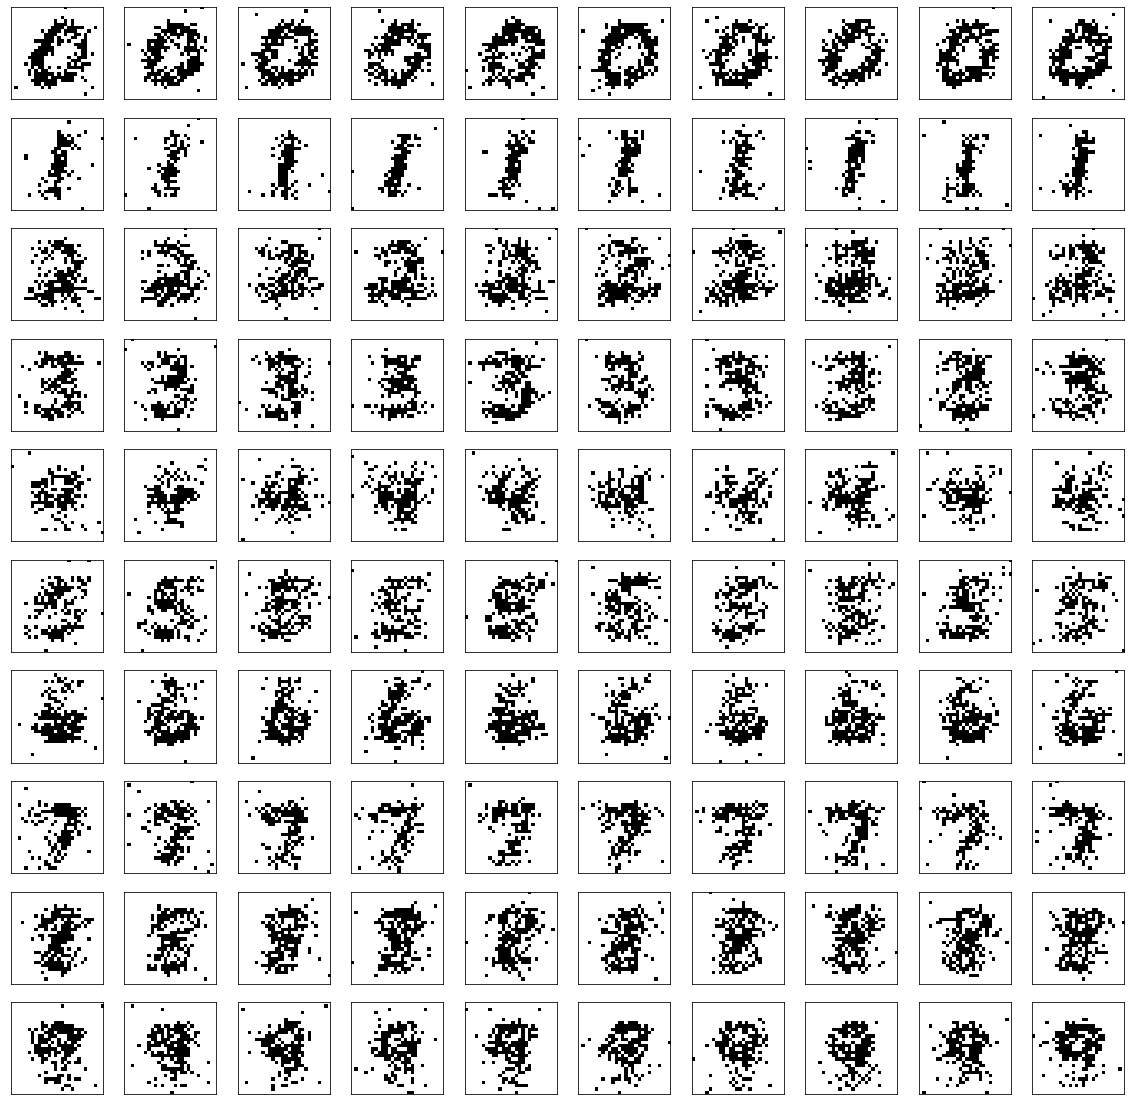

In [8]:
def Q5(num_examples):
  '''Produces a Bernoulli Naive Bayes model to generate a 10x10 grid of examples images for each digit'''
  ### STUDENT START ###
  # Using BernoulliNB to produce a model using Bernoulli Naive Bayes: 
  bernoulli_nb = BernoulliNB(binarize = 0.1) 
  # Fitting the model on the mini train data and mini train labels: 
  bernoulli_nb_fit = bernoulli_nb.fit(mini_train_data, mini_train_labels)

  # Finding the estimated probability of each pixel being 0 or 1 is stored in the model's feature_log_prob_ attribute
  # Using np.exp() to convert a log probability back to a probability
  pixel_probabilities = np.exp(bernoulli_nb_fit.feature_log_prob_)

  # Similar to number 1 in project 1, creating subplots with the number of rows equal to the number of unique elements in Y and the number of columns equal to 10, with a set figure size of 20x20:
  fig, axs = plt.subplots(len(np.unique(Y)), 10, figsize=(20,20)) 
  
  # Iterating through each of the 10 possible digit options: 
  for digit in range(10):
    # Composing the grid variable with only images of digits that have higher probabilities than the ones that were randomly generated:
    # Using np.random.rand() to generate random numbers from a uniform distribution:
      grid = pixel_probabilities[digit] > np.random.rand(num_examples, 28 * 28)
      # Iterating through the number of images to print for each digit (10 as per directions):
      for image in range(num_examples): 
          # Reshaping and displaying the images: 
          axs[digit, image].imshow(grid[image].reshape((int(np.sqrt(X.shape[1])), int(np.sqrt(X.shape[1])))), cmap='Greys') 
          # Removing ticks and associated numerical values from each subplot: 
          axs[digit, image].set_xticks([], []) 
          axs[digit, image].set_yticks([], []) 
### STUDENT END ###

Q5(10)

ANSWER: When comparing the generated digit images to the training digit images, the generated digits look a lot more blurry and scattered and are not too distinguishable or readable. Connecting this back to the course material, it is harder to tell which digit is being portrayed in each image becayse Naive Bayes makes the assumption that there is independence between all pixels, which are the features in this case, which is not necessarily a valid assumption here.

The training digit images were binarized with a threshold of 0.1 such that a higher threshold corresponds to a blurrier image. After this, the dataset produced was dependent on the probability of the pixel having a higher probability compared to the randomly generated number. Therefore, if the shape of the number was not as clear or distinguishable, with variation in pixel values, it became more blurry.

### Question 6: Model Calibraiton
---
Recall that:
 * a **strongly calibrated** classifier is rougly 90% accurate when it says it is 90% accurate. The model's estimated posterior probability of the predicted class is indeed 0.9. 
 * A **weakly calibrated** classifier is more accurate when it "says" it is more accurate. The actual accuracy is higher when the model's estimated posterior probability is higher.
 * A **poorly calibrated** classifier has no positive correlation between the model's estimate posterior probability and the actual accuracy.

1. Produce a Bernoulli Naive Bayes model.  
1. Evaluate performance: 
  1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
    - Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
    - Then estimate the actual accuracy the classifier achieved for each bucket. 
    - So, for each prediction:
       - Find the bucket whose range includes the estimated posterior probability, 
       - and update "correct" and "total" counters accordingly. 
       - Show the accuracy for each bucket.
1. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.



In [9]:
def Q6(buckets, correct, total):
  '''Produces a Bernoulli Naive Bayes model and evaluates performance by partitioning the dev set into several buckets based on the estimated posterior probabilities of the predicted classes'''
  ### STUDENT START ###
  # Using BernoulliNB to produce the model with the LaPlace smoothing set to the optimal value: 
  bernoulli_nb = BernoulliNB(alpha = 0.01, binarize = 0)
  # Fitting the model on the mini train data and mini train labels: 
  bernoulli_nb.fit(mini_train_data, mini_train_labels)

  # Iterating through the dev data: 
  for x in np.arange(0, len(dev_data), 1):
      # Set the estimated posterior probabilities to the the probability of the predicted development data label being any digits from 0 - 9:
      estimated_posterior_probs = bernoulli_nb.predict_proba(dev_data)[x]
      # Bucket the data based on the max of the estimated posterior probabilities: 
      # We use the max of the estimated posterior probabilities because this is the predicted development data label, or the probability of the correct predicted digit given the digit:
      the_list = iter(buckets.index(bucket) for bucket in buckets if max(estimated_posterior_probs) <= bucket)
      bucketed = next(the_list)
      # Increase the number corresponding to the total bucketed data: 
      total[bucketed] += 1
      # If the bucketed data is correct out of the total data, then increase the number corresponding to the correct bucketed data: 
      if list(estimated_posterior_probs).index(max(estimated_posterior_probs)) == int(dev_labels[x]): 
          correct[bucketed] +=1         
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

Q6(buckets, correct, total)

# For testing purposes: 
for x in range(len(buckets)):
  if total[x] != 0:
    print('bucket = %.13f     total = %3d     accuracy = %.2f' %(buckets[x], total[x], (correct[x] / total[x]) * 100) + "%")

bucket = 0.9000000000000     total =  32     accuracy = 34.38%
bucket = 0.9990000000000     total =  71     accuracy = 39.44%
bucket = 0.9999900000000     total =  53     accuracy = 56.60%
bucket = 0.9999999000000     total =  49     accuracy = 57.14%
bucket = 0.9999999990000     total =  55     accuracy = 80.00%
bucket = 0.9999999999900     total =  48     accuracy = 68.75%
bucket = 0.9999999999999     total =  39     accuracy = 84.62%
bucket = 1.0000000000000     total = 653     accuracy = 94.03%


ANSWER: Based on the definitions above, I would characterize the calibration for this Bernoulli Naive Bayes model as weakly calibrated as the actual accuracy is not always higher when the model's estimated posterior probability is higher. A higher confidence corresponds to a higher accuracy, but for the case where the total is 48 and the bucket bound is 0.9999999999900, the accuracy is not higher than that corresponding to a lower estimated posterior probability hence the direction of the accuracy cannot be accurately predicted based on the posterior. 


### Question 7 EXTRA CREDIT: Feature generation
---
1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
1. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

**Note that improving results is actually hard.**

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try implementing [*maxpool*](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) features, taking a rolling maximum over sub-regions of a the image. 
- In any case, you can either transform the original data or add new "features" to it.

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [ ]:
def Q7():

### STUDENT START ###

### STUDENT END ###

Q7()